In [ ]:
!python --version
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --config python3
!python3 --version
!sudo apt install python3-pip

Python 3.7.15
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.7   1         auto mode
  1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode
Python 3.6.9
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
 

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
import math
from tensorflow.keras.models import load_model
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure
from skimage import filters

import matplotlib.pyplot as plt
import pandas as pd

from google.colab.patches import cv2_imshow
from scipy import stats
import sys

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_names(path):
    names = []
    paths = []
    pIDs = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext in ['.png']:
                names.append(filename)
                paths.append(root+"/"+filename)
                pIDs.append(root.replace((os.path.dirname(root)+"/"), ''))
#                 print()
#                 print(root)
#                 print(filename)
#                 print(root.replace((os.path.dirname(root)+"/"), ''))
    return (names, paths, pIDs)

In [ ]:
imagePath = '/content/drive/My Drive/MCL/Gloria photos standardised/clean GLORIA'

names, paths, pIDs = get_names(imagePath)

print(pIDs[0])

FR


In [ ]:
patientV = []
for i in range(len(paths)):
  # print(paths[i].split("/")[8])
  patientV.append(paths[i].split("/")[8])

print(len(paths))
print(patientV[0])
print(paths[0])

2803
304006_B
/content/drive/My Drive/MCL/Gloria photos standardised/clean GLORIA/clean GLORIA 4/304006_B/FR/304006-b-foot-both.dcm-rotated.png


In [ ]:
overviewPath = '/content/drive/My Drive/MCL/Gloria fims submitted/SUPER submitted for reading.xlsx'
presenceOverview = pd.read_excel(overviewPath, sheet_name="Blad1")

dataPath = '/content/drive/MyDrive/MCL/Gloria output_Lezer 2_01Mar2021_correcties verwisselingen-analyse-allesNB.xlsx'
data = pd.read_excel(dataPath, sheet_name="Lezer 2-Vertical")

IMG_WIDTH_hands = 128 * 3
IMG_HEIGHT_hands = 128 * 6

IMG_WIDTH_feet = 128 * 3
IMG_HEIGHT_feet = 128 * 6 

N_trainsamples = 1516

X_train_H = np.zeros((N_trainsamples, IMG_HEIGHT_hands, IMG_WIDTH_hands), dtype=np.uint8)
X_train_F = np.zeros((N_trainsamples, IMG_HEIGHT_feet, IMG_WIDTH_feet), dtype=np.uint8)

Y_train_H = np.zeros(N_trainsamples)
Y_train_F = np.zeros(N_trainsamples)

Y_index = 0
X_index = 0
for column, id in tqdm(enumerate(presenceOverview.iterrows()), total=519):
  # print(column)
  # print(id[1][0])
  if math.isnan(id[1][0]) == False: 
    pID = int(id[1][0])


  if pID < 1000:
    continue
  

  series = data['Patient ID']
  # Visit A handling
  try:
    index  = series[series == pID].index[0] #index[0] here is visit A
    # This gives an error if the Patient ID does not exist within GLORIA data file but does exist within SUPER submitted, write an exception!!!

    # Y_train handling
    LHscore = data.loc[index, 'TOTAL SCORES LH ER'] + data.loc[index, 'TOTAL SCORES LH JSN']
    RHscore = data.loc[index, 'TOTAL SCORES RH ER'] + data.loc[index, 'TOTAL SCORES RH JSN']
    LFscore = data.loc[index, 'TOTAL SCORES LF ER'] + data.loc[index, 'TOTAL SCORES LF JSN']
    RFscore = data.loc[index, 'TOTAL SCORES RF ER'] + data.loc[index, 'TOTAL SCORES RF JSN']

    Y_train_H[Y_index] = LHscore
    Y_train_F[Y_index] = LFscore
    Y_index += 1
    
    Y_train_H[Y_index] = RHscore
    Y_train_F[Y_index] = RFscore
    Y_index += 1

    # X_train handling
    ## NOTE: file locations are stored with LimbSide (e.g. HL) as oposed to scores which use SideLimb (e.g. LH)
    for path in paths:
      if str(pID) + "_A" in path:
        usePath = path
    usePath = usePath.split("/")[:-2]
    usePath = "/".join(usePath)

    _, p, _ = get_names(usePath + "/HL")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    LHimage = img

    _, p, _ = get_names(usePath + "/HR")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    RHimage = img

    _, p, _ = get_names(usePath + "/FL")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    LFimage = img

    _, p, _ = get_names(usePath + "/FR")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    RFimage = img

    X_train_H[X_index] = LHimage
    X_train_F[X_index] = LFimage
    X_index += 1
    
    X_train_H[X_index] = RHimage
    X_train_F[X_index] = RFimage
    X_index += 1
  except IndexError:
    continue

  # Visit B handling
  try:
    index  = series[series == pID].index[1] #index[1] here is visit B
    # This gives an error if the Patient ID does not exist within GLORIA data file but does exist within SUPER submitted, write an exception!!!

    # Y_train handling
    LHscore = data.loc[index, 'TOTAL SCORES LH ER'] + data.loc[index, 'TOTAL SCORES LH JSN']
    RHscore = data.loc[index, 'TOTAL SCORES RH ER'] + data.loc[index, 'TOTAL SCORES RH JSN']
    LFscore = data.loc[index, 'TOTAL SCORES LF ER'] + data.loc[index, 'TOTAL SCORES LF JSN']
    RFscore = data.loc[index, 'TOTAL SCORES RF ER'] + data.loc[index, 'TOTAL SCORES RF JSN']

    Y_train_H[Y_index] = LHscore
    Y_train_F[Y_index] = LFscore
    Y_index += 1
    
    Y_train_H[Y_index] = RHscore
    Y_train_F[Y_index] = RFscore
    Y_index += 1

    # X_train handling
    ## NOTE: file locations are stored with LimbSide (e.g. HL) as oposed to scores which use SideLimb (e.g. LH)
    for path in paths:
      if str(pID) + "_B" in path: # OMG WTF THIS SHOULD BE _B
        usePath = path
    usePath = usePath.split("/")[:-2]
    usePath = "/".join(usePath)

    _, p, _ = get_names(usePath + "/HL")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    LHimage = img

    _, p, _ = get_names(usePath + "/HR")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    RHimage = img

    _, p, _ = get_names(usePath + "/FL")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    LFimage = img

    _, p, _ = get_names(usePath + "/FR")
    img = cv2.imread(p[0], cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (IMG_WIDTH_hands, IMG_HEIGHT_hands))
    RFimage = img

    X_train_H[X_index] = LHimage
    X_train_F[X_index] = LFimage
    X_index += 1
    
    X_train_H[X_index] = RHimage
    X_train_F[X_index] = RFimage
    X_index += 1
  except IndexError:
    continue 
  
  # print(index)  
  # print(data.loc[index, 'Patient ID'])
  # print()



    


100%|██████████| 519/519 [1:04:25<00:00,  7.45s/it]


In [ ]:
print(len(Y_train_H))
print(len(Y_train_F))

1516
1516


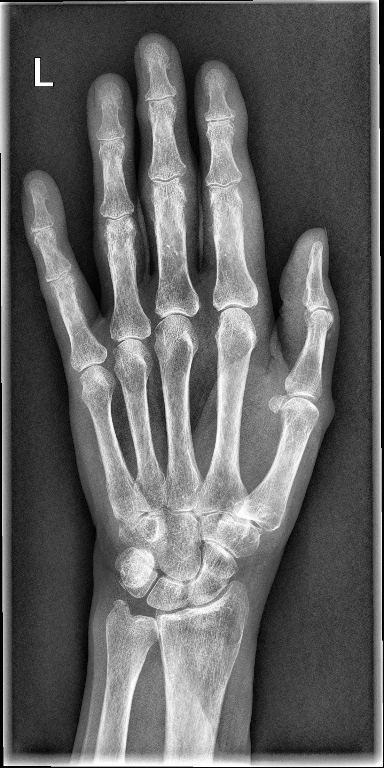

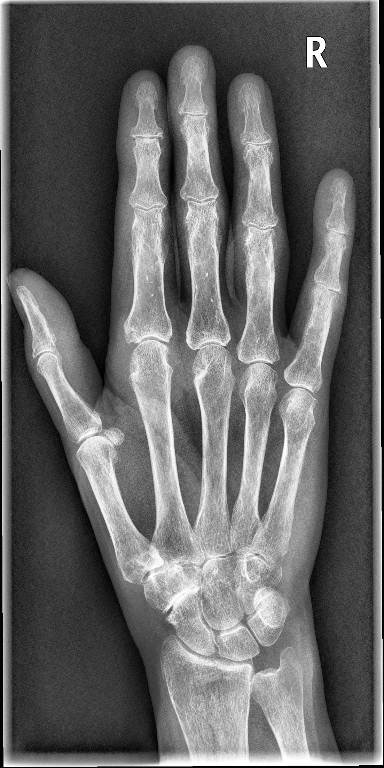

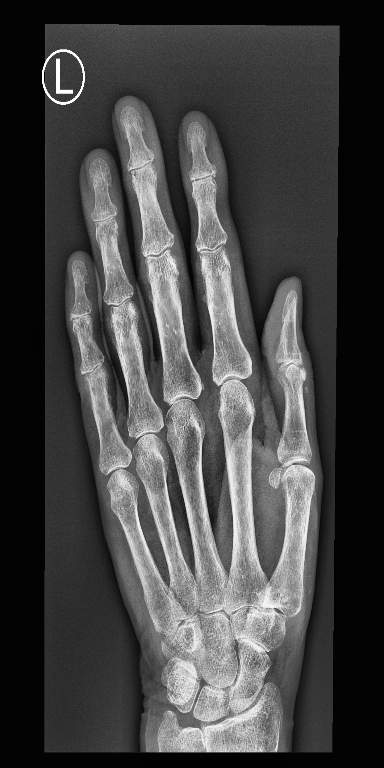

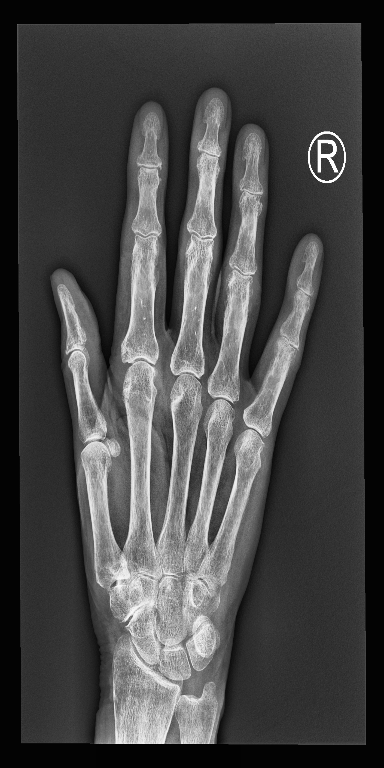

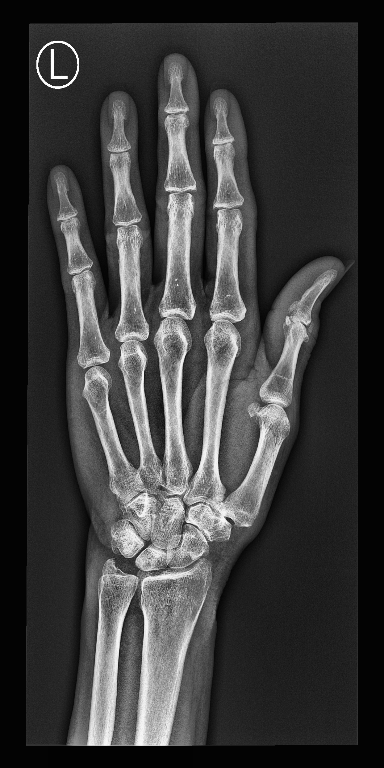

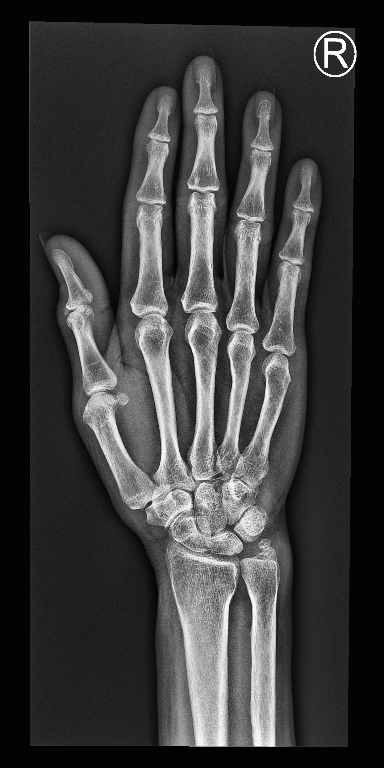

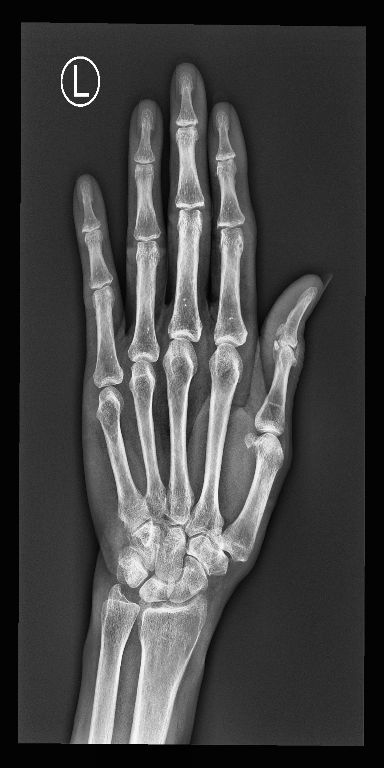

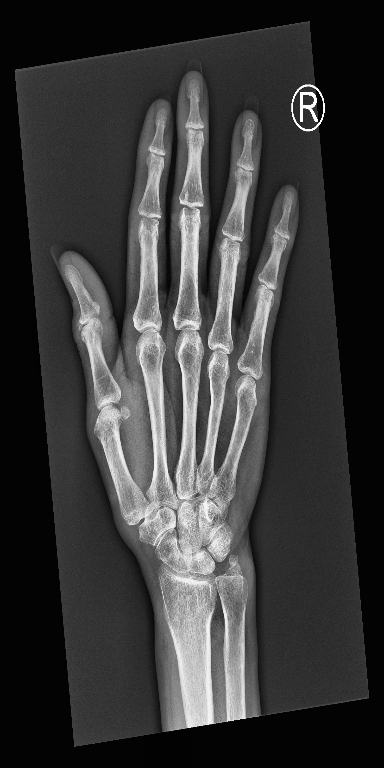

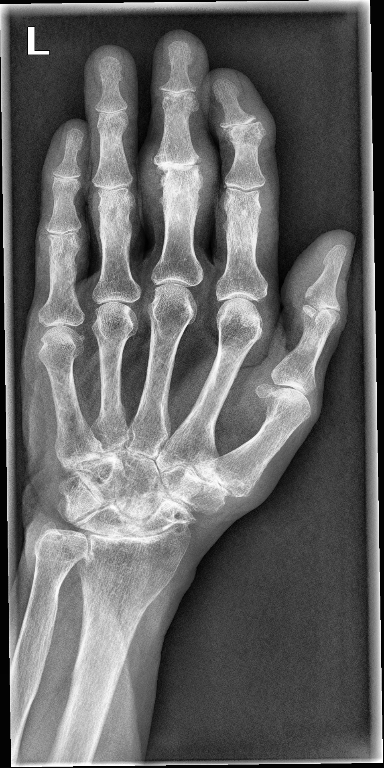

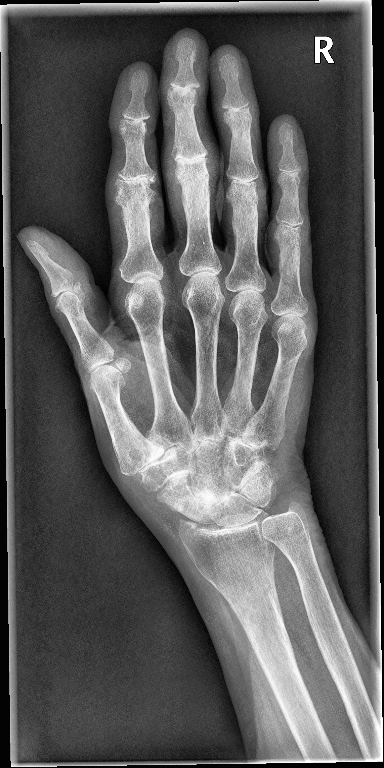

In [ ]:
for i in range(0,10):
  # if i % 2 == 0:
  cv2_imshow(X_train_H[i])

In [ ]:
from scipy import stats
import sys

def postProcesROI (img, pred):
  # Load images
  image = img
  prediction = pred

  # Convert prediction into cv2 object
  plt.imsave('test.png', prediction)
  prediction = cv2.imread('test.png', 0)

  # Clean the prediction for close to zero pixel values (this cleans up the cut with the original image later)
  percentiles = np.percentile(prediction, (40, 99))
  prediction = exposure.rescale_intensity(prediction,
                                  in_range=tuple(percentiles))
  prediction = exposure.adjust_gamma(prediction, gamma=0.90,gain=1)

  # Blur the mask for cleaner end result (kind of optional tbh)
  blur = cv2.GaussianBlur(prediction, (3,3), 0)

  # Find all contours of the mask
  cnts = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  # Calculate which generated contour is an outlier
  cnts_clean = []
  area_limit = 500
  # An area size of 200 is chosen since in all the training and test sets not a single contour 
  # of area > 200 and area < 1000 is found (whitch might've indicated very small joints but is never the case)
  for i in range(len(cnts)):
    area = cv2.contourArea(cnts[i])
    # Now remove the small outliers from the contour listing (this is for cropping later)
    if area > area_limit:
      cnts_clean.append(cnts[i])
    if area < area_limit:
      # Just to be sure; paint all small areas black as they are not joints 
      cv2.drawContours(blur, [cnts[i]], -1, (0,0,0), -1)

  # Combine the outermost parts of each contour to get the extreme points of the whole mask
  leftmost = sys.maxsize
  rightmost = 0
  topmost = sys.maxsize
  bottommost = 0
  for i in range(len(cnts_clean)):
    c = cnts_clean[i]
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])
    
    leftmost = min(left[0], leftmost)
    rightmost = max(right[0], rightmost)
    topmost = min(top[1], topmost)
    bottommost = max(bottom[1], bottommost)  

  # Cut image based on (inverted) mask
  invMask = cv2.bitwise_not(blur)
  result = cv2.subtract(image,invMask)

  # Show / return result
  ROI = result[topmost:bottommost, leftmost:rightmost]
  return ROI

In [ ]:
import keras
keras.__version__

'2.9.0'

In [ ]:
# Select all ROI's masks

# ROI for hands is trained on 200 images
import_hands_path = '/content/drive/My Drive/MCL/U4_T150_3x6.h5'
# import_hands_path = '/content/drive/My Drive/MCL/U4_T200_3x6(NEW).h5'
model_hands = load_model(import_hands_path)

# ROI for feet is trained on 200 images
import_feet_path = '/content/drive/My Drive/MCL/U4_T150_3x6_feet.h5'
# import_feet_path = '/content/drive/My Drive/MCL/U5_T200_3x6_feet(NEW).h5'
model_feet = load_model(import_feet_path)

# Get HL mask
preds_train_H = model_hands.predict(X_train_H, batch_size=10 ,verbose=1)
preds_train_t_H = (preds_train_H > 0.5).astype(np.uint8)

# Get FL mask
preds_train_F = model_feet.predict(X_train_F, batch_size=10 ,verbose=1)
preds_train_t_F = (preds_train_F > 0.5).astype(np.uint8)


152/152 [==============================] - 18s 119ms/step


In [ ]:
# Post process the masks
IMG_WIDTH_h = 128 * 3
IMG_HEIGHT_h = 128 * 6 

IMG_WIDTH_f = 128 * 3
IMG_HEIGHT_f = 128 * 3 

X_H = np.zeros((N_trainsamples, IMG_HEIGHT_h, IMG_WIDTH_h), dtype=np.uint8)
X_F = np.zeros((N_trainsamples, IMG_HEIGHT_f, IMG_WIDTH_f), dtype=np.uint8)


for n, id_ in tqdm(enumerate(X_H), total=N_trainsamples):
  # postprocess ROI H
  image = X_train_H[n]
  prediction = np.squeeze(preds_train_t_H[n])
  img = postProcesROI(image, prediction)
  img = cv2.resize(img, (IMG_WIDTH_h, IMG_HEIGHT_h))
  # img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
  X_H[n] = img


  # postprocess ROI F
  image = X_train_F[n]
  prediction = np.squeeze(preds_train_t_F[n])
  img = postProcesROI(image, prediction)
  img = cv2.resize(img, (IMG_WIDTH_f, IMG_HEIGHT_f))
  X_F[n] = img


100%|██████████| 1516/1516 [03:16<00:00,  7.71it/s]


In [ ]:
# Sanity check
from google.colab.patches import cv2_imshow

# cv2_imshow(X_train_H[46])
for i in range(200):
  cv2_imshow(X_F[i])
  print(i)
  print()

In [ ]:
from google.colab import files

indexes_H = [1,2,3,4,6,7,8,10,11,13,16,17,19,20,22,23,24,25,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,44,45,46,47,48,49,50,51,54,55,56,57,58,59,60,61,62]
print(len(indexes_H))
indexes_F = range(50)
print(len(indexes_F))
os.mkdir("Hands")
os.mkdir("Feet")
for a in indexes_H:
  image = cv2.imwrite("Hands/H_img" + str(a) + ".png",X_train_H[a])
for b in indexes_F:
  image = cv2.imwrite("Feet/F_img" + str(b) + ".png",X_train_F[b])


50
50


In [ ]:
for a in indexes_H:
  files.download("H_img" + str(a) + ".png") 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for b in indexes_F:
  files.download("F_img" + str(b) + ".png") 

In [ ]:
!zip -r /content/file.zip /content/Feet

files.download("/content/file.zip")

  adding: content/Feet/ (stored 0%)
  adding: content/Feet/F_img44.png (deflated 0%)
  adding: content/Feet/F_img45.png (deflated 0%)
  adding: content/Feet/F_img19.png (deflated 0%)
  adding: content/Feet/F_img16.png (deflated 0%)
  adding: content/Feet/F_img24.png (deflated 1%)
  adding: content/Feet/F_img0.png (deflated 0%)
  adding: content/Feet/F_img29.png (deflated 0%)
  adding: content/Feet/F_img17.png (deflated 0%)
  adding: content/Feet/F_img37.png (deflated 0%)
  adding: content/Feet/F_img32.png (deflated 0%)
  adding: content/Feet/F_img39.png (deflated 0%)
  adding: content/Feet/F_img1.png (deflated 0%)
  adding: content/Feet/F_img8.png (deflated 1%)
  adding: content/Feet/F_img38.png (deflated 0%)
  adding: content/Feet/F_img28.png (deflated 0%)
  adding: content/Feet/F_img2.png (deflated 1%)
  adding: content/Feet/F_img23.png (deflated 1%)
  adding: content/Feet/F_img30.png (deflated 0%)
  adding: content/Feet/F_img22.png (deflated 1%)
  adding: content/Feet/F_img25.png (d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

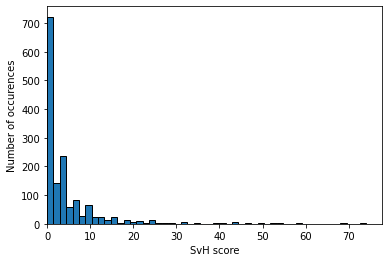

In [ ]:
plt.hist(Y_train_H, bins=50, edgecolor="black")
plt.xlabel("SvH score")
plt.ylabel("Number of occurences")
plt.xlim(0)
plt.show()

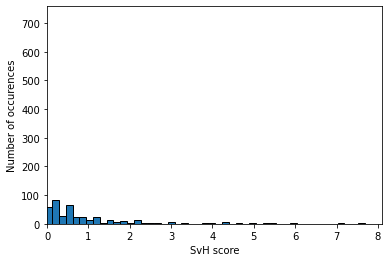

In [ ]:
from scipy.stats import zscore

Y_H = zscore(Y_train_H)
Y_F = zscore(Y_train_F)

plt.hist(Y_H, bins=50, edgecolor="black")
plt.xlabel("SvH score")
plt.ylabel("Number of occurences")
plt.xlim(0)
plt.show()

**HANDS HERE**

In [ ]:
# Define hand model
inputsH = tf.keras.layers.Input((IMG_HEIGHT_h, IMG_WIDTH_h,1))
sh = tf.keras.layers.Lambda(lambda x: x / 255)(inputsH)

# Contraction path Hands_Left
c1h = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sh)
c1h = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1h)
p1h = tf.keras.layers.MaxPooling2D((2, 2))(c1h)

c2h = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1h)
c2h = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2h)
p2h = tf.keras.layers.MaxPooling2D((2, 2))(c2h)

c3h = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2h)
c3h = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3h)
c3h = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3h)
p3h = tf.keras.layers.MaxPooling2D((2, 2))(c3h)

c4h = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3h)
c4h = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4h)
c4h = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4h)
p4h = tf.keras.layers.MaxPooling2D((2, 2))(c4h)

c5h = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4h)
c5h = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5h)
c5h = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5h)
p5h = tf.keras.layers.MaxPooling2D((2, 2))(c5h)

f6h = tf.keras.layers.Flatten()(p5h)

d7h = tf.keras.layers.Dense(1024, activation='relu')(f6h)
d8h = tf.keras.layers.Dense(512, activation='relu')(d7h)
# a6h = tf.keras.layers.Activation('relu')(d5h)
# outputsH = tf.keras.layers.Normalization(axis=None)(a6h)
outputsH = tf.keras.layers.Dense(1, activation='linear')(d8h)

modelH = tf.keras.Model(inputs=[inputsH], outputs=[outputsH])
# Set smaller learning rate since dataset is small
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelH.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
# modelH.summary()

In [ ]:
valCutoff = int(len(X_H) * 0.8) # use 20% of training for testing validation
trainXH = X_train_H[:valCutoff]
testXH = X_train_H[valCutoff:]
trainYH = Y_train_H[:valCutoff]
testYH = Y_train_H[valCutoff:]

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_hand_scan.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = modelH.fit(trainXH, trainYH, validation_split=0.1, batch_size=10, epochs=20, callbacks=callbacks,)

Epoch 1/20
109/109 [==============================] - 13s 96ms/step - loss: 92.7245 - accuracy: 0.1477 - val_loss: 63.0317 - val_accuracy: 0.0902
Epoch 2/20
109/109 [==============================] - 10s 94ms/step - loss: 89.1497 - accuracy: 0.1422 - val_loss: 61.5456 - val_accuracy: 0.0902
Epoch 3/20
109/109 [==============================] - 10s 93ms/step - loss: 86.2728 - accuracy: 0.1422 - val_loss: 62.2382 - val_accuracy: 0.0902
Epoch 4/20
109/109 [==============================] - 10s 96ms/step - loss: 80.6753 - accuracy: 0.1477 - val_loss: 69.3515 - val_accuracy: 0.0902
Epoch 5/20
109/109 [==============================] - 10s 93ms/step - loss: 73.4577 - accuracy: 0.1440 - val_loss: 64.3981 - val_accuracy: 0.0984
Epoch 6/20
109/109 [==============================] - 10s 95ms/step - loss: 62.9954 - accuracy: 0.1532 - val_loss: 77.8444 - val_accuracy: 0.0902
Epoch 7/20
109/109 [==============================] - 10s 92ms/step - loss: 52.2085 - accuracy: 0.1514 - val_loss: 66.1886 -

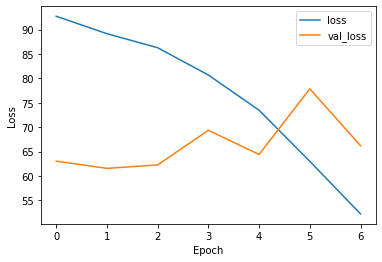

In [ ]:
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')

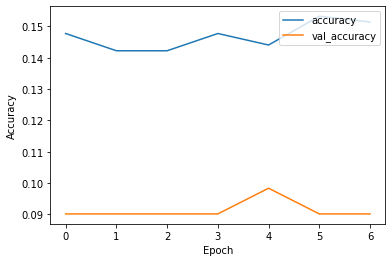

In [ ]:
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')

31/31 [==============================] - 2s 53ms/step
training results


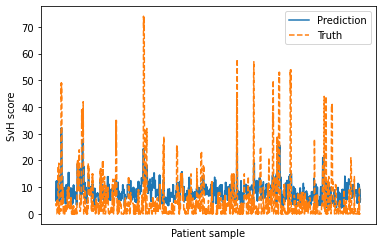

test results
Test accuracy is: 0.0
Test mean squared error is: 88.91466104172177
Test mean absolute error is: 7.958290291852073
Train mean squared error is: 74.0163962749062
Train mean absolute error is: 6.534764375426982


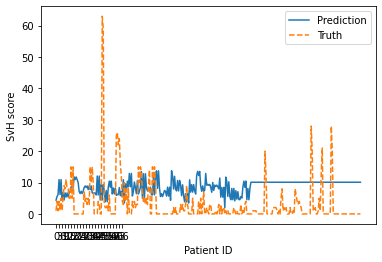

In [ ]:
# get predictions
preds_trainH = modelH.predict(trainXH, batch_size=10 ,verbose=1) 

preds_testH = modelH.predict(testXH, batch_size=10, verbose=1)

# print(preds_trainH[0])
# for i in range(len(Y_train_HL)):
#   print(str(preds_trainH[i][0]), "vs", str(Y_train_HL[i]))

# print("training results")
# for i in range(len(trainYH)):
#   print(str(preds_trainH[i][0]), "vs", str(trainYH[i]))

easy_trainH = []
print("training results")
for i in range(len(trainYH)):
  easy_trainH.append(preds_trainH[i][0])

plt.plot(easy_trainH, label="Prediction")
plt.plot(trainYH, label="Truth", linestyle="--")
plt.xlabel('Patient sample')
plt.xticks([])
plt.ylabel('SvH score')
plt.legend(loc='best')
plt.show()

easy_testH = []
accuracy = 0
print("test results")
for i in range(len(testYH)):
  # print(str(preds_testH[i][0]), "vs", str(testYH[i]))
  if preds_testH[i][0] == testYH[i]:
    accuracy += 1
  easy_testH.append(preds_testH[i][0])

accuracy = accuracy / len(testYH)
print("Test accuracy is:", accuracy)
MSE_H = np.square(np.subtract(testYH,easy_testH)).mean()
print("Test mean squared error is:", MSE_H)
mae_H = np.absolute(np.subtract(testYH, easy_testH)).mean()
print("Test mean absolute error is:", mae_H)

MSE_F = np.square(np.subtract(trainYH,easy_trainH)).mean()
print("Train mean squared error is:", MSE_F)
mae_F = np.absolute(np.subtract(trainYH, easy_trainH)).mean()
print("Train mean absolute error is:", mae_F)

plt.plot(easy_testH, label="Prediction")
plt.plot(testYH, label="Truth", linestyle="--")
plt.xlabel('Patient ID')
plt.xticks(np.arange(0, 67, 3))
plt.ylabel('SvH score')
plt.legend(loc='best')
plt.show()


In [ ]:
stats.ttest_rel(testYH, easy_testH)
print(len(easy_testH))

304


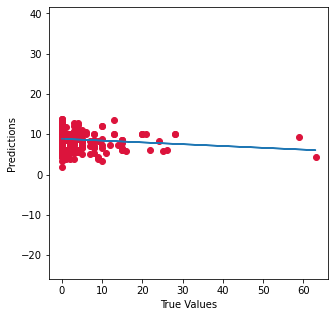

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(testYH, easy_testH, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

# p1 = max(max(easy_testH), max(testYH))
# p2 = min(min(easy_testH), min(testYH))
# plt.plot([p1, p2], [p1, p2], 'b-')

m, b = np.polyfit(testYH, easy_testH, 1)

plt.plot(testYH, m*testYH + b)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()

In [ ]:
# Pearson's R coefficent 
print(np.corrcoef(testYH, easy_testH))

[[ 1.         -0.14135548]
 [-0.14135548  1.        ]]
